# FIB-SEM Registration (FFT)

http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/

Maybe I should be doing everything in terms of a homography matrix, then everything is matrix multiply.

In [17]:
%matplotlib inline
import numpy as np
# better image reader than np
from scipy.misc import imread, imsave
import matplotlib.pyplot as plt
# three different registration packages
# not dft based
import cv2
# dft based
from skimage.feature import register_translation
# parallel processing tools
import dask
import dask.multiprocessing
# so we know where we are
from dask.diagnostics import ProgressBar
# Need a container for registration results
from functools import namedtuple

In [28]:
import scipy.ndimage.interpolation as ndii
import pyfftw
pyfftw.interfaces.cache.enable()
from pyfftw.interfaces.numpy_fft import *
# __version__ = '2013.01.18'
# __docformat__ = 'restructuredtext en'
# __all__ = ['translation', 'similarity']


def translation(im0, im1):
    """Return translation vector to register images."""
    shape = im0.shape
    f0 = fft2(im0)
    f1 = fft2(im1)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = np.unravel_index(np.argmax(ir), shape)
    if t0 > shape[0] // 2:
        t0 -= shape[0]
    if t1 > shape[1] // 2:
        t1 -= shape[1]
    return [t0, t1]


def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    - can fix with padding, non-square images can be handled either with padding or
        better yet compensating for uneven image size
    All image areas must have same scale, rotation, and shift.
    - tiling if necessary...
    Scale change must be less than 1.8.
    - why?
    No subpixel precision.
    - fit peak position or upsample as in (https://github.com/scikit-image/scikit-image/blob/master/skimage/feature/register_translation.py)

    """
    if im0.shape != im1.shape:
        raise ValueError("Images must have same shapes.")
    elif len(im0.shape) != 2:
        raise ValueError("Images must be 2 dimensional.")
    # calculate fourier images of inputs
    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))
    # high pass filter fourier images
    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
#     del h
    # convert images to logpolar coordinates.
    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)
    # fourier transform again ?
    f0 = fft2(f0)
    f1 = fft2(f1)
    # calculate impulse response
    r0 = abs(f0) * abs(f1)
    ir = abs(ifft2((f0 * f1.conjugate()) / r0))
    # find max
    i0, i1 = np.unravel_index(np.argmax(ir), ir.shape)
    # calculate the angle
    angle = 180.0 * i0 / ir.shape[0]
    # and scale
    scale = log_base ** i1
    # if scale is too big, try the negative angle and inverse scale
    if scale > 1.8:
        ir = abs(ifft2((f1 * f0.conjugate()) / r0))
        i0, i1 = np.unravel_index(np.argmax(ir), ir.shape)
        angle = -180.0 * i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError("Images are not compatible. Scale change > 1.8")
    # center the angle
    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0
    # apply scale and rotation
    im2 = ndii.zoom(im1, 1.0/scale)
    im2 = ndii.rotate(im2, angle)
    # resize image to fit, but this can be done above.
    if im2.shape < im0.shape:
        t = np.zeros_like(im0)
        t[:im2.shape[0], :im2.shape[1]] = im2
        im2 = t
    elif im2.shape > im0.shape:
        im2 = im2[:im0.shape[0], :im0.shape[1]]
    # now calculate translation, this should be done with the above function
    f0 = fft2(im0)
    f1 = fft2(im2)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = np.unravel_index(np.argmax(ir), ir.shape)
    # compensate for wraparound
    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]
    # shift the image.
    im2 = ndii.shift(im2, [t0, t1])

    # correct parameters for ndimage's internal processing
    if angle > 0.0:
        d = int((int(im1.shape[1] / scale) * np.sin(np.radians(angle))))
        t0, t1 = t1, d+t0
    elif angle < 0.0:
        d = int((int(im1.shape[0] / scale) * np.sin(np.radians(angle))))
        t0, t1 = d+t1, d+t0
    scale = (im1.shape[1] - 1) / (int(im1.shape[1] / scale) - 1)

    return im2, scale, angle, [-t0, -t1]


# Use skimage AffineTransform for this.
def similarity_matrix(scale, angle, vector):
    """Return homogeneous transformation matrix from similarity parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector (of size 2).

    The order of transformations is: scale, rotate, translate.

    """
    S = np.diag([scale, scale, 1.0])
    R = np.identity(3)
    angle = np.radians(angle)
    R[0, 0] = np.cos(angle)
    R[1, 1] = np.cos(angle)
    R[0, 1] = -np.sin(angle)
    R[1, 0] = np.sin(angle)
    T = np.identity(3)
    T[:2, 2] = vector
    return np.dot(T, np.dot(R, S))


def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = np.empty((angles, radii), dtype=np.float64)
    theta.T[:] = -np.linspace(0, np.pi, angles, endpoint=False)
    #d = radii
    d = np.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (np.log10(d) / (radii))
    radius = np.empty_like(theta)
    radius[:] = np.power(log_base, np.arange(radii,
                                                   dtype=np.float64)) - 1.0
    x = radius * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    # inverse cosine filter.
    x = np.outer(
        np.cos(np.linspace(-np.pi/2., np.pi/2., shape[0])),
        np.cos(np.linspace(-np.pi/2., np.pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)
#     return x


# def imread(fname, norm=True):
#     """Return image data from img&hdr uint8 files."""
#     with open(fname+'.hdr', 'r') as fh:
#         hdr = fh.readlines()
#     img = np.fromfile(fname+'.img', np.uint8, -1)
#     img.shape = int(hdr[4].split()[-1]), int(hdr[3].split()[-1])
#     if norm:
#         img = img.astype(np.float64)
#         img /= 255.0
#     return img


# def imshow(im0, im1, im2, im3=None, cmap=None, **kwargs):
#     """Plot images using matplotlib."""
#     from matplotlib import pyplot
#     if cmap is None:
#         cmap = 'coolwarm'
#     if im3 is None:
#         im3 = abs(im2 - im0)
#     pyplot.subplot(221)
#     pyplot.imshow(im0, cmap, **kwargs)
#     pyplot.subplot(222)
#     pyplot.imshow(im1, cmap, **kwargs)
#     pyplot.subplot(223)
#     pyplot.imshow(im3, cmap, **kwargs)
#     pyplot.subplot(224)
#     pyplot.imshow(im2, cmap, **kwargs)
#     pyplot.show()

In [19]:
from scipy.ndimage import affine_transform

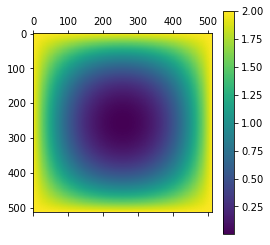

In [29]:
plt.matshow(highpass((512, 512)))
plt.colorbar()

In [31]:
# testing
from skimage.data import astronaut
from skimage.color import rgb2gray

import scipy.ndimage as ndii

# need class for registration params, no skew yet ...
RegistrationParams = namedtuple("RegistrationParams", ["y", "x", "angle", "scale", "skew"])

# trans_mat is not necessary, translation is supplied as offset to affine_transform
def rot_mat(angle, input_shape):
    """This is more complicated because we want to rotate about the center."""
    m11 = np.cos(angle)
    m12 = np.sin(angle)
    m21 = -np.sin(angle)
    m22 = np.cos(angle)
    matrix = np.array([[m11, m12],
                             [m21, m22]], dtype=np.float64)
    iy, ix = oy, ox = input_shape

    offset = np.zeros((2,), dtype=np.float64)
    offset[0] = float(oy) / 2.0 - 0.5
    offset[1] = float(ox) / 2.0 - 0.5
    offset = np.dot(matrix, offset)
    tmp = np.zeros((2,), dtype=np.float64)
    tmp[0] = float(iy) / 2.0 - 0.5
    tmp[1] = float(ix) / 2.0 - 0.5
    offset = tmp - offset
    
    return matrix, offset
        
def scale_mat(scale, data_shape):
    """return scale matrix"""
    data_shape = np.asarray(data_shape)
    new_data_shape = (data_shape * scale).astype(int)
    return np.diag((data_shape - 1) / (new_data_shape - 1))

def reg_params_to_mat(reg_params, data_shape):
    """Take a RegistrationParams instance and turn it into an affine transformation matrix and offset"""
    rot, offset = rot_mat(reg_params.angle, data_shape)
    offset -= np.array((reg_params.y, reg_params.x))
    mat = scale_mat(reg_params.scale, data_shape).dot(rot)
    return dict(matrix=mat, offset=offset)

def apply_affine(img, reg_params, **kwargs):
    kwargs.update(reg_params_to_mat(reg_params, img.shape))
    return affine_transform(img, **kwargs)

In [32]:
astro = rgb2gray(astronaut())
test_params = RegistrationParams(10, 20, 0, 1, 0)

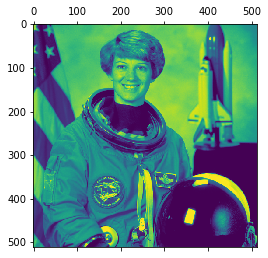

In [34]:
plt.matshow(astro)

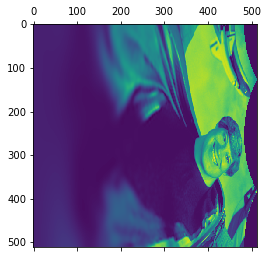

In [35]:
plt.matshow(logpolar(astro)[0])

In [40]:
reg_params_to_mat(test_params, astro.shape)

{'matrix': array([[ 1.,  0.],
        [ 0.,  1.]]), 'offset': array([ 10.,  20.])}

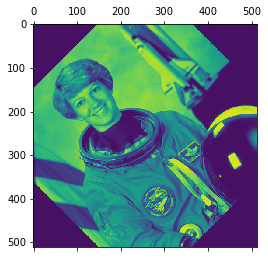

In [51]:
plt.matshow(ndi.rotate(astro, 45, reshape=False))

In [52]:
test1 = ndi.rotate(astro, 45, reshape=False)
test_params = RegistrationParams(0, 0, np.pi/4, 1, 0)
test2 = apply_affine(astro, test_params)
np.allclose(test1, test2)

True

In [53]:
test1 = ndi.shift(astro, (10, 20))
test_params = RegistrationParams(10, 20, 0, 1, 0)
test2 = apply_affine(astro, test_params)
np.allclose(test1, test2)

True

In [100]:
test1 = ndi.zoom(astro[:256], 2)[:256, :512]
test_params = RegistrationParams(0, 0, 0, 2, 0)
test2 = apply_affine(astro[:256], test_params)
np.allclose(test1, test2)

True

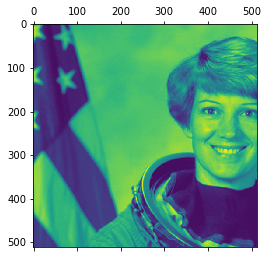

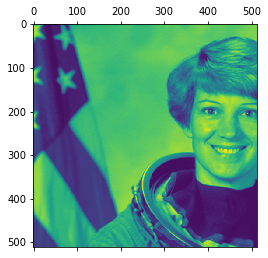

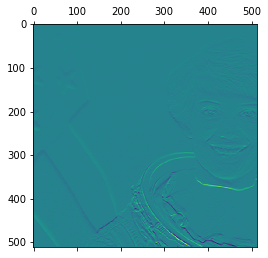

In [94]:
plt.matshow(test1)
plt.matshow(test2)
plt.matshow(test1-test2)

In [109]:
# imreg_dft does it this way, but it doesn't agree with ndimage, will have to test.
# test1 = ndi.zoom(astro, 2)
# test1 = ndi.rotate(test1, 45, reshape=False)
# test1 = ndi.shift(test1, (10, 20))

test1 = ndi.shift(astro, (10, 20))
test1 = ndi.rotate(test1, 45, reshape=False)
test1 = ndi.zoom(test1, 2)[:512, :512]

test_params = RegistrationParams(10, 20, np.pi/4, 2, 0)
test2 = apply_affine(astro, test_params)
np.allclose(test1[200:, 200:], test2[200:, 200:])

False

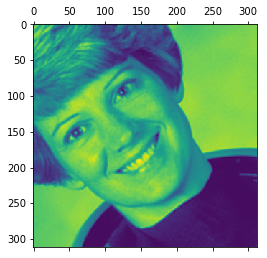

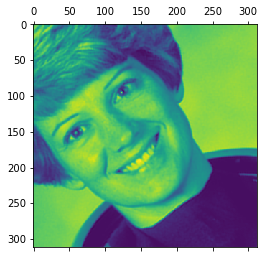

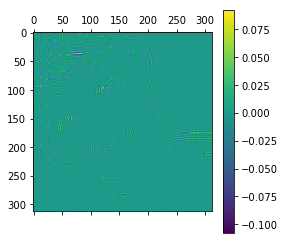

In [111]:
plt.matshow(test1[200:, 200:])
plt.matshow(test2[200:, 200:])
plt.matshow((test1 - test2)[200:, 200:])
plt.colorbar()

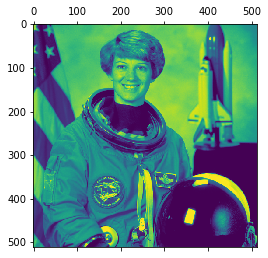

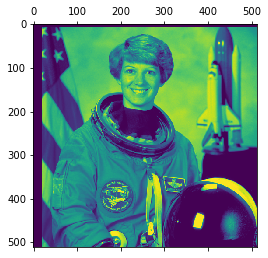

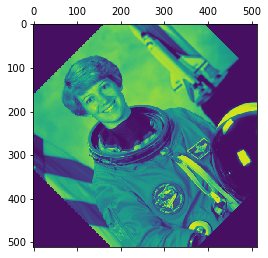

In [65]:
plt.matshow(astro)
test_params = RegistrationParams(10, 20, 0, 1, 0)
plt.matshow(apply_affine(astro, test_params))
test_params = RegistrationParams(10, 20, np.pi/4, 1, 0)
plt.matshow(apply_affine(astro, test_params))

In [ ]:
# test against transform_img
imreg_dft.transform_img

In [1]:
from skimage.transform import AffineTransform

In [5]:
import np as np

In [8]:
af = AffineTransform(np.array(((1, 2, 3), (4, 5, 6), (0, 0, 1))))

In [13]:
af.rotation

1.3258176636680326